## Outlier detection methods
Exploration of various methods to filter out outliers in tracking phantom eye models. All of these are based on suspicious jumps in radius size.

### 1. Imports

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import RANSACRegressor
from statsmodels.tsa.api import SimpleExpSmoothing

from helpers.limbus_detection import detect_circle
from helpers.view_detection import get_view_mask


%load_ext autoreload
%autoreload 2

/Users/mirek/Documents/Custom_Surgical/Cataract-Surgery-Training-Explorations/.venv/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 2. Simple methods video demo (optional)

In [6]:
%%capture

WINDOW_SIZE = 20

cap = cv2.VideoCapture('data/artificial/rhexis_input_augmented.mp4')
circles = []
while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break

    # output image for different methdos
    base_naive = base.copy()
    base_mean = base.copy()
    base_median = base.copy()
    base_ses = base.copy()

    # hsv conversion
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_value = base_hsv[:, :, 2]

    # fetching the view mask
    view_mask = get_view_mask(base_value, radius_shrink=0.90)

    # limbus circle detection
    cur_circle = detect_circle(
        base_value,
        view_mask=view_mask,
        validation='inout',
        validation_mode='min',
        validation_value_thresh=0.0,
        considered_ratio_s=0.1,
        circle_width_to_radius_ratio=0.1
    )

    # no circle detected
    if cur_circle is not None:
        circles.append(cur_circle)
        if len(circles) > WINDOW_SIZE:
            circles = circles[1:]

    if circles:
        best_circle = circles[-1]
        cv2.circle(base_naive, (round(best_circle[0]), round(best_circle[1])), round(
            best_circle[2]), (0, 255, 0), lineType=cv2.LINE_AA)
        best_circle = np.mean(circles, axis=0)
        cv2.circle(base_mean, (round(best_circle[0]), round(best_circle[1])), round(
            best_circle[2]), (0, 255, 0), lineType=cv2.LINE_AA)
        best_circle = np.median(circles, axis=0)
        cv2.circle(base_median, (round(best_circle[0]), round(best_circle[1])), round(
            best_circle[2]), (0, 255, 0), lineType=cv2.LINE_AA)
        if len(circles) > 1:
            best_circle = np.array((
                SimpleExpSmoothing(np.array(circles)[:, 0]).fit(
                    smoothing_level=0.2, optimized=False).forecast(0)[0],
                SimpleExpSmoothing(np.array(circles)[:, 1]).fit(
                    smoothing_level=0.2, optimized=False).forecast(0)[0],
                SimpleExpSmoothing(np.array(circles)[:, 2]).fit(
                    smoothing_level=0.2, optimized=False).forecast(0)[0]
            ))
            cv2.circle(base_ses, (round(best_circle[0]), round(best_circle[1])), round(
                best_circle[2]), (0, 255, 0), lineType=cv2.LINE_AA)

    if view_mask is not None:
        cv2.imshow('view mask', view_mask)

    cv2.imshow('vanilla', base_naive)
    cv2.imshow('mean', base_mean)
    cv2.imshow('median', base_median)
    cv2.imshow('single exponential smoothing', base_ses)

    if cv2.waitKey(25) == ord('q'):
        break

cap.release()
for _ in range(10):
    cv2.destroyAllWindows()
    cv2.waitKey(1)


### 3. Saving circle detections for further processing (optional)

In [ ]:
CIRCLES_COUNT = 400

cap = cv2.VideoCapture('data/artificial/rhexis_input_augmented.mp4')
circles = []
while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break

    # hsv conversion
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_value = base_hsv[:, :, 2]

    # fetching the view mask
    view_mask = get_view_mask(base_value, radius_shrink=0.90)

    # limbus circle detection
    cur_circle = detect_circle(
        base_value,
        view_mask=view_mask,
        validation='inout',
        validation_mode='min',
        validation_value_thresh=0.0,
        considered_ratio_s=0.1,
        circle_width_to_radius_ratio=0.1
    )

    if cur_circle is not None:
        circles.append(cur_circle)

cap.release()

circles = np.array(circles)
np.save('data/variables/outlier_detection_methods__circles.npy', circles)


### 4. Loading circle detections

In [3]:
circles = np.load('data/variables/outlier_detection_methods__circles.npy')
circles = np.array(circles)
circles1 = circles[:200]    # 1st 200-frame slice
circles2 = circles[200:400]  # 2nd 200-frame slice
circles3 = circles[400:600]  # 3rd 200-frame slice

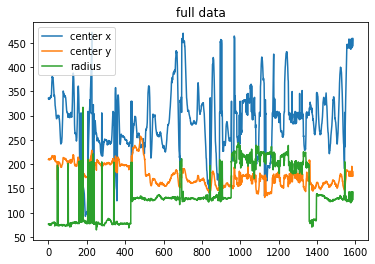

In [4]:
plt.title('full data')
plt.plot(circles[:, 0], label='center x')
plt.plot(circles[:, 1], label='center y')
plt.plot(circles[:, 2], label='radius')
plt.legend(loc='upper left')

plt.show()

### 5. Simple exponential smoothing

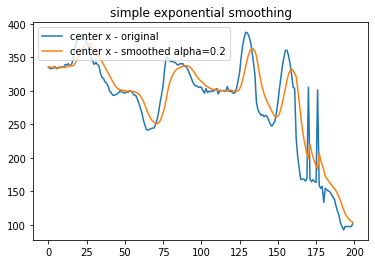

In [5]:
circles1_x = circles1[:, 0]
ses1 = SimpleExpSmoothing(circles1_x).fit(
    smoothing_level=0.2, optimized=False
)

plt.title('simple exponential smoothing')
plt.plot(circles1_x, label='center x - original')
plt.plot(ses1.fittedvalues, label='center x - smoothed alpha=0.2')
plt.legend(loc='upper left')

plt.show()


### 3. Robust line fitting

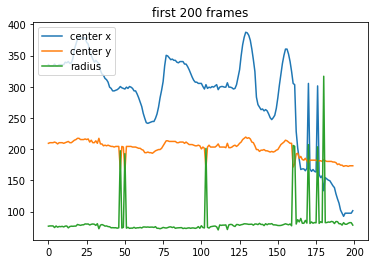

In [6]:
plt.title('first 200 frames')
plt.plot(circles1[:, 0], label='center x')
plt.plot(circles1[:, 1], label='center y')
plt.plot(circles1[:, 2], label='radius')
plt.legend(loc='upper left')

plt.show()

Fitting line to radius values with RANSAC

In [7]:
X, y = np.arange(circles1.shape[0]).reshape(-1, 1), circles1[:, 2]
regressor = RANSACRegressor(random_state=0).fit(X, y)

Determining outliers

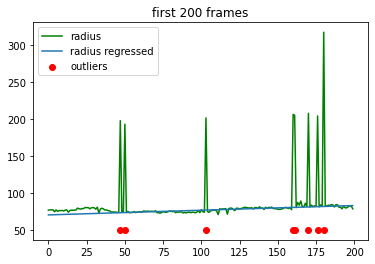

In [8]:
FOOTAGE_SHAPE = (360, 640)
outliers = np.where((
    np.abs(circles1[:, 2] - regressor.predict(X))
    / np.max(FOOTAGE_SHAPE))
    > 0.1)[0]

plt.title('first 200 frames')
plt.plot(circles1[:, 2], label='radius', color='green')
plt.plot(regressor.predict(X), label='radius regressed')
plt.scatter(outliers, 50*np.ones_like(outliers), color='red', label='outliers')
plt.legend(loc='upper left')

plt.show()

Replacing outliers with preceeding value

In [9]:
circles1_r_filtered = circles1[:, 2].copy()
for o in outliers:
    if o == 0:
        continue
    circles1_r_filtered[o] = circles1_r_filtered[o - 1]

### 4. Single exponential smoothing on filtered signal

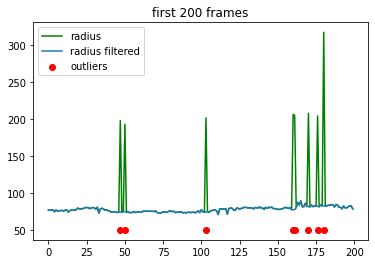

In [10]:
plt.title('first 200 frames')
plt.plot(circles1[:, 2], label='radius', color='green')
plt.plot(circles1_r_filtered, label='radius filtered')
plt.scatter(outliers, 50*np.ones_like(outliers), color='red', label='outliers')
plt.legend(loc='upper left')

plt.show()

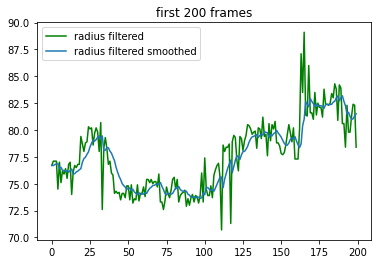

In [11]:
ses1 = SimpleExpSmoothing(circles1_r_filtered).fit(
    smoothing_level=0.2, optimized=False
)

plt.title('first 200 frames')
plt.plot(circles1_r_filtered, label='radius filtered', color='green')
plt.plot(ses1.fittedvalues, label='radius filtered smoothed')
plt.legend(loc='upper left')

plt.show()

### 5. Using median for outlier detection

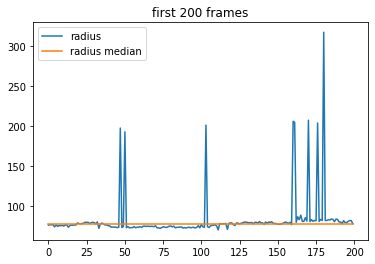

In [12]:
radius_median = np.median(circles1[:, 2])

plt.title('first 200 frames')
plt.plot(circles1[:, 2], label='radius')
plt.plot(np.ones_like(circles1[:, 2])*radius_median, label='radius median')
plt.legend(loc='upper left')

plt.show()

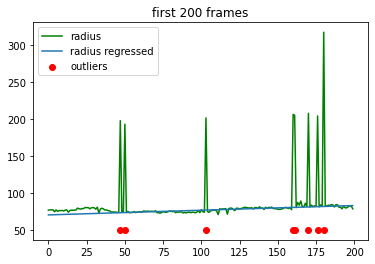

In [13]:
outliers = np.where((
    np.abs(circles1[:, 2] - radius_median)
    / np.max(FOOTAGE_SHAPE))
    > 0.1)[0]

plt.title('first 200 frames')
plt.plot(circles1[:, 2], label='radius', color='green')
plt.plot(regressor.predict(X), label='radius regressed')
plt.scatter(outliers, 50*np.ones_like(outliers), color='red', label='outliers')
plt.legend(loc='upper left')

plt.show()

### 6. Simple methods v. our custom one video demo

In [14]:
def custom_method(circles: np.array, footage_shape: tuple = FOOTAGE_SHAPE, smoothing: str = 'ses') -> np.array:
    assert smoothing in (
        'ses', 'mean'), 'smoothing method \'%s\' is not supported' % smoothing

    circles = np.array(circles)

    # no filtering done when only one circle passed
    if len(circles) < 2:
        return circles[0]

    # robust line fitting
    X, y = np.arange(circles.shape[0]).reshape(-1, 1), circles[:, 2]
    regressor = RANSACRegressor(random_state=0).fit(X, y)

    # filtering outliers based on distance from the fitted line
    outliers = np.where((
        np.abs(circles[:, 2] - regressor.predict(X))
        / np.max(footage_shape))
        > 0.1)[0]

    # replacing outliers with preceeding values in the window
    circles_filtered = circles.copy()
    for o in outliers:
        if o == 0:
            continue
        circles_filtered[o] = circles_filtered[o - 1]

    # smoothing application
    best_circle = None
    if smoothing == 'ses':
        best_circle = np.array((
            SimpleExpSmoothing(circles_filtered[:, 0]).fit(
                smoothing_level=0.2, optimized=False
            ).forecast(0)[0],
            SimpleExpSmoothing(circles_filtered[:, 1]).fit(
                smoothing_level=0.2, optimized=False
            ).forecast(0)[0],
            SimpleExpSmoothing(circles_filtered[:, 2]).fit(
                smoothing_level=0.2, optimized=False
            ).forecast(0)[0]
        ))
    elif smoothing == 'mean':
        best_circle = np.mean(circles_filtered, axis=0)

    return best_circle

In [15]:
%%capture

WINDOW_SIZE = 20

cap = cv2.VideoCapture('data/artificial/rhexis_input_augmented.mp4')
circles_window = []
while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break

    # output image for different methdos
    base_naive = base.copy()
    base_mean = base.copy()
    base_median = base.copy()
    base_custom_ses = base.copy()
    base_custom_mean = base.copy()

    # hsv conversion
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_value = base_hsv[:, :, 2]

    # fetching the view mask
    view_mask = get_view_mask(base_value, radius_shrink=0.90)

    # limbus circle detection
    cur_circle = detect_circle(
        base_value,
        view_mask=view_mask,
        validation='inout',
        validation_mode='min',
        validation_value_thresh=0.0,
        considered_ratio_s=0.1,
        circle_width_to_radius_ratio=0.1
    )

    if cur_circle is not None:
        circles_window.append(cur_circle)
        if len(circles_window) > WINDOW_SIZE:
            circles_window = circles_window[1:]

    if circles_window:
        best_circle = circles_window[-1]
        cv2.circle(base_naive, (round(best_circle[0]), round(best_circle[1])), round(
            best_circle[2]), (0, 255, 0), lineType=cv2.LINE_AA)
        best_circle = np.mean(circles_window, axis=0)
        cv2.circle(base_mean, (round(best_circle[0]), round(best_circle[1])), round(
            best_circle[2]), (0, 255, 0), lineType=cv2.LINE_AA)
        best_circle = np.median(circles_window, axis=0)
        cv2.circle(base_median, (round(best_circle[0]), round(best_circle[1])), round(
            best_circle[2]), (0, 255, 0), lineType=cv2.LINE_AA)
        best_circle = custom_method(
            circles_window, footage_shape=base_value.shape, smoothing='ses')
        if best_circle is not None:
            cv2.circle(base_custom_ses, (round(best_circle[0]), round(best_circle[1])), round(
                best_circle[2]), (0, 255, 0), lineType=cv2.LINE_AA)
        best_circle = custom_method(
            circles_window, footage_shape=base_value.shape, smoothing='mean')
        if best_circle is not None:
            cv2.circle(base_custom_mean, (round(best_circle[0]), round(
                best_circle[1])), round(best_circle[2]), (0, 255, 0), lineType=cv2.LINE_AA)

    if view_mask is not None:
        cv2.imshow('view mask', view_mask)

    cv2.imshow('vanilla', base_naive)
    cv2.imshow('mean', base_mean)
    cv2.imshow('median', base_median)
    cv2.imshow('custom + single exponential smoothing', base_custom_ses)
    cv2.imshow('custom + mean', base_custom_mean)

    if cv2.waitKey(25) == ord('q'):
        break

cap.release()
for _ in range(10):
    cv2.destroyAllWindows()
    cv2.waitKey(1)


### 7. OpenCV based line fitting methods

`cv2.fitLine()` returns normalized vector `(vx,vy)` and point `(x0,y0)`, then the equation of the line is:
<br>
`(x,y) = (x0,y0) + t*(vx,vy)`

In [16]:
def plot_opencv_line(line, color='blue', label='opencv line', scale=1e10):
    xs = [line[0] - scale*line[2],
          line[0] + scale*line[2]]
    ys = [line[1] - scale*line[3],
          line[1] + scale*line[3]]
    plt.plot(xs, ys, color=color, label=label)

[]

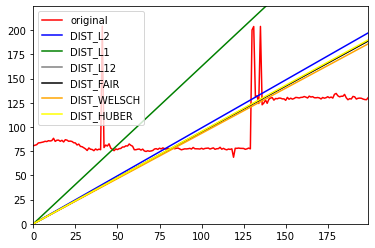

In [17]:
circles1_r = circles[300:500, 2]
points = np.array([np.arange(circles1_r.size), circles1_r]).T

plt.plot(circles1_r, color='red', label='original')

line = cv2.fitLine(points, cv2.DIST_L2, 0, 1e-2, 1e-2)
plot_opencv_line(line, color='blue', label='DIST_L2')
line = cv2.fitLine(points, cv2.DIST_L1, 0, 1e-2, 1e-2)
plot_opencv_line(line, color='green', label='DIST_L1')
line = cv2.fitLine(points, cv2.DIST_L12, 0, 1e-2, 1e-2)
plot_opencv_line(line, color='grey', label='DIST_L12')
line = cv2.fitLine(points, cv2.DIST_FAIR, 0, 1e-2, 1e-2)
plot_opencv_line(line, color='black', label='DIST_FAIR')
line = cv2.fitLine(points, cv2.DIST_WELSCH, 0, 1e-2, 1e-2)
plot_opencv_line(line, color='orange', label='DIST_WELSCH')
line = cv2.fitLine(points, cv2.DIST_HUBER, 0, 1e-2, 1e-2)
plot_opencv_line(line, color='yellow', label='DIST_HUBER')

plt.xlim([0, points[-1, 0]])
plt.ylim([0, np.max(points[:, 1])*1.1])
plt.legend(loc='upper left')

plt.plot()

Conclusion: Not really applicable

### 8. Using HoughLines
Could be better at handling changing zoom levels.

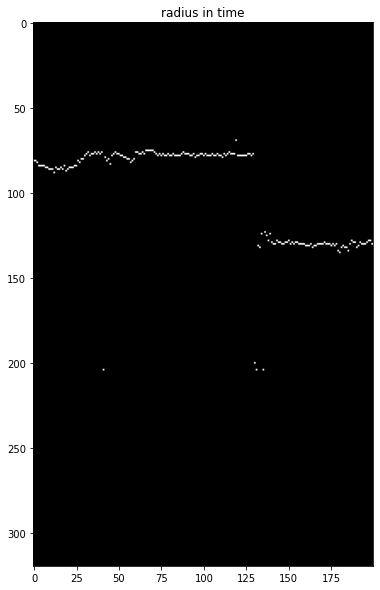

In [18]:
radius_image = np.zeros(
    (np.max(base_value.shape)//2, points.shape[0]), dtype='uint8')
for p in points:
    radius_image[round(p[1]), round(p[0])] = 255

fig, plot = plt.subplots(1, 1, figsize=(20, 10))
plt.title('radius in time')
plot.imshow(radius_image, cmap='gray')
plt.show()

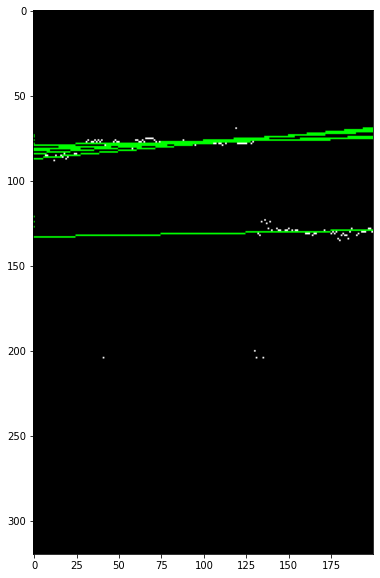

In [19]:
lines = cv2.HoughLines(radius_image, 1, np.pi/180, radius_image.shape[1]//10)

radius_image_base = cv2.cvtColor(radius_image, cv2.COLOR_GRAY2RGB)
for line in lines:
    line = line[0]
    p1 = (0, round(line[0] / np.sin(line[1])))
    p2 = (round(line[0] / np.cos(line[1])), 0)
    try:
        cv2.line(radius_image_base, p1, p2, (0, 255, 0))
    except:
        pass

fig, plot = plt.subplots(1, 1, figsize=(20, 10))
plot.imshow(radius_image_base)
plt.show()

Line clustering could help at tackling zoom level discontinuities. Doable but too much of a hassle for now.